# Imports

In [1]:
import SpotCurve.Spot_Curve_Calculator as sc
import matplotlib.pyplot as plt
import pandas as pd
import mpl_bsic
import importlib
import Returns.RollDown as rd
from Utils.data_processing import process_data
import Utils.CrossSectional_Regression as csr

importlib.reload(sc)
importlib.reload(rd)
importlib.reload(csr)

<module 'Utils.CrossSectional_Regression' from '/Users/vittoriomanfriani/PycharmProjects/backtesting series - episode 3/Utils/CrossSectional_Regression.py'>

# Load Data

In [2]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/BSIC/Datasets/bond_data_auction.parquet')
# take data only from 2010-01-01
data = data.loc[(data.index.get_level_values(0) >= '2010-01-01') & (data.index.get_level_values(0) <= '2024-10-02')]

# Apply Bootstrapper

In [3]:
spot_rates_calculator = sc.SpotRatesCalculator()

In [4]:
zero_curve_df = spot_rates_calculator.apply_bootstrapper(data,freq = 'tenors')

100%|██████████| 3847/3847 [00:51<00:00, 74.23it/s]


# Apply Nelson Siegel

In [5]:
loadings_df = spot_rates_calculator.apply_nelson_siegel(zero_curve_df, ridge=True)

100%|██████████| 3847/3847 [00:12<00:00, 313.46it/s]


In [6]:
loadings_df.head()

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2010-01-01,5.443239,-5.781663,-1.441757,1.938513
2010-01-04,5.504061,-5.516690,-2.074482,1.956500
2010-01-05,5.474688,-5.727790,-1.768542,1.999573
2010-01-06,5.584800,-5.710578,-2.048267,2.001441
2010-01-07,5.554065,-5.966374,-1.522045,2.013505


## Interpolate with Nelson-Siegel-Svensonn

In [32]:
interpolated_curve_df = spot_rates_calculator.interpolate_nelson_siegel(loadings_df, freq = 'quarterly')

100%|██████████| 3847/3847 [00:03<00:00, 1235.41it/s]


### Plot and compare the two curves

fonts already added so will not add again


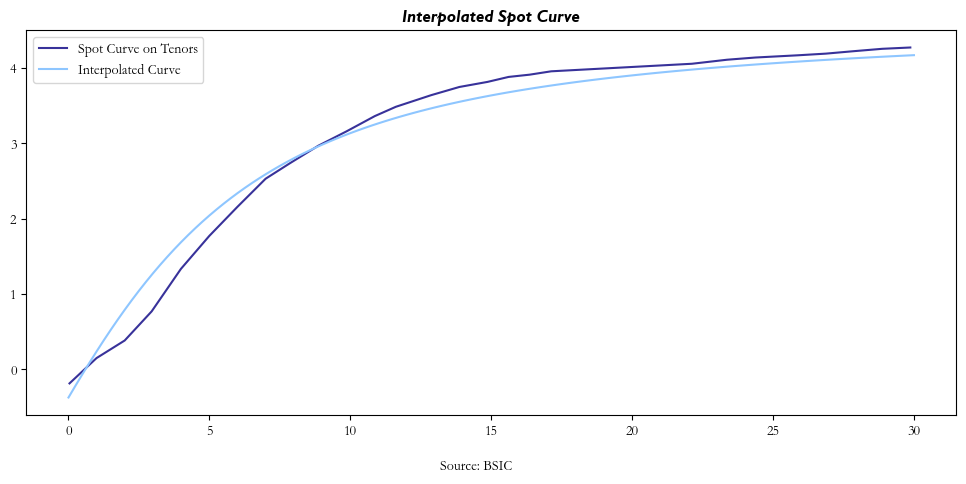

In [37]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(zero_curve_df.loc['2014-01-01', 'Maturities'], zero_curve_df.loc['2014-01-01','Curve'], label = 'Spot Curve on Tenors')
ax.plot(interpolated_curve_df.loc['2014-01-01', 'Maturities'], interpolated_curve_df.loc['2014-01-01','Curve'], label = 'Interpolated Curve')
ax.legend()
ax.set_title('Interpolated Spot Curve')
mpl_bsic.apply_bsic_style(fig, ax)


# Compute Returns

## Overall returns

In [11]:
# Function to compute returns
def compute_gross_returns(df):
    # Calculate daily coupons (coupon/365) and lagged price
    df.loc[:, 'daily_coupons'] = df['coupon'] / 365
    df.loc[:, 'prev_price'] = df.groupby('id')['price'].shift(1)  # Lagged price for each bond

    # Compute returns using the formula
    df.loc[:, 'returns'] = ((df['price'] + df['daily_coupons']) - df['prev_price']) / df['prev_price']

    return df

In [12]:
data = process_data(data)
data = compute_gross_returns(data)

# Carry

In [13]:
def compute_carry(df):
    df['carry'] = df['daily_coupons'] / df['prev_price']
    return df

In [14]:
data = compute_carry(data)

## RollDown

In [15]:
data = rd.compute_rolldown(data)

100%|█████████▉| 3846/3847 [06:58<00:00,  9.19it/s]


## Excess returns

In [16]:
data['Excess Returns'] = data['returns'] - data['carry'] - data['rolldown']

# Cross Sectional Regression

In [17]:
params = csr.cross_sectional_regression_nelson_siegel(data, loadings_df)

100%|██████████| 3847/3847 [00:06<00:00, 565.34it/s]


In [36]:
params.mean()

date         2017-05-18 20:46:25.647425792
const                             0.000377
beta1                             0.000574
beta2                            -0.003003
r_squared                         0.638678
dtype: object